In [85]:
# Import modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import math
import optuna
import numpy as np

In [86]:
def set_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        print(f'Using device: {device}')
        print(f'GPU: {torch.cuda.get_device_name(0)}')
    else:
        print(f'Using device: {device}')

    return device

In [87]:
def norm_data(name):
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }

    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    # Get the unique experiment numbers in order
    exp_num_list = sorted(ndf['exp'].unique())
    return ndf, exp_num_list

In [88]:
def seq_data(ndf):
    seq = []
    # 전류(I)는 포함: ground truth로 사용하여 예측 성능 비교
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp].sort_values(by='t')
        seq.append(exp_data[feature_cols].values)
    
    return seq

In [89]:
def pad_seq(seq):
    max_len = max([len(seq) for seq in seq])
    seq_len = [len(seq) for seq in seq]
    pad_seq = pad_sequence([torch.tensor(seq) for seq in seq], batch_first=True, padding_value=-1)

    return pad_seq, seq_len, max_len

In [90]:
def gen_dataset(pad_seq, seq_len):
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [91]:
def dataloaders(dataset, exp_num_list, batch_size=4):
    """
    Split the dataset into train/val/test with 8:1:1 ratio
    
    Args:
        dataset: TensorDataset
        exp_num_list: list of experiment numbers
        batch_size: batch size
        random_state: random seed
        
    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """

    
    # required train experiment numbers
    required_train_exps = [0, 5, 8, 10, 15, 17, 20, 21, 22, 23, 30]
    
    # all experiment numbers
    all_exps = exp_num_list
    total_exps = len(all_exps)
    
    # batch_size
    batch_size = math.ceil(len(dataset)/10)

    # 8:1:1 ratio
    train_count = int(total_exps * 0.8)
    val_count = math.ceil(total_exps * 0.1)
    
    # remaining experiments
    remaining_exps = [exp for exp in all_exps if exp not in required_train_exps]
    
    # number of experiments to add to train
    additional_train_needed = train_count - len(required_train_exps)
    
    if additional_train_needed < 0:
        raise ValueError("The number of required train experiments is greater than the total train set. Please adjust required_train_exps.")
    
    # shuffle remaining experiments
    np.random.shuffle(remaining_exps)
    
    # split remaining experiments into train, val, test
    train_exps = required_train_exps + remaining_exps[:additional_train_needed]
    val_exps = remaining_exps[additional_train_needed:additional_train_needed + val_count]
    test_exps = remaining_exps[additional_train_needed + val_count:]
    
    print(f"Actual split:")
    print(f"  Train: {sorted(train_exps)} ({len(train_exps)} experiments)")
    print(f"  Val: {sorted(val_exps)} ({len(val_exps)} experiments)")  
    print(f"  Test: {sorted(test_exps)} ({len(test_exps)} experiments)")
    
    # find indices of each experiment (exp_num_list and dataset have the same order)
    train_indices = []
    val_indices = []
    test_indices = []
    
    for idx, exp in enumerate(all_exps):
        if exp in train_exps:
            train_indices.append(idx)
        elif exp in val_exps:
            val_indices.append(idx)
        elif exp in test_exps:
            test_indices.append(idx)
    
    # split dataset into train, val, test
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    # create DataLoader
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    print(f"\nCompleted DataLoader creation:")
    print(f"  Train: {len(train_subset) if train_subset else 0} sequences")
    print(f"  Val: {len(val_subset) if val_subset else 0} sequences")
    print(f"  Test: {len(test_subset) if test_subset else 0} sequences")
    
    return train_loader, val_loader, test_loader

In [92]:
class LayerNormLSTMCell(nn.Module):
    """LSTM Cell with Layer Normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node
        
        # Input-to-hidden and hidden-to-hidden transformations
        self.weight_ih = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.weight_hh = nn.Linear(hidden_node, 4 * hidden_node, bias=False)
        
        # Layer normalization for each gate
        self.ln_i = nn.LayerNorm(hidden_node)  # Input gate
        self.ln_f = nn.LayerNorm(hidden_node)  # Forget gate  
        self.ln_g = nn.LayerNorm(hidden_node)  # Cell gate
        self.ln_o = nn.LayerNorm(hidden_node)  # Output gate
        
        # Cell state layer norm
        self.ln_c = nn.LayerNorm(hidden_node)
        
    def forward(self, input, hidden):
        h_prev, c_prev = hidden
        
        # Input-to-hidden and hidden-to-hidden transformations
        gi = self.weight_ih(input)    # [batch, 4*hidden_size] - 입력에 대한 4개 게이트 계산
        gh = self.weight_hh(h_prev)   # [batch, 4*hidden_size] - 이전 히든 상태에 대한 4개 게이트 계산
        i_i, i_f, i_g, i_o = gi.chunk(4, 1)
        h_i, h_f, h_g, h_o = gh.chunk(4, 1)
        
        # Apply layer normalization to each gate
        i_gate = torch.sigmoid(self.ln_i(i_i + h_i))
        f_gate = torch.sigmoid(self.ln_f(i_f + h_f))  
        g_gate = torch.tanh(self.ln_g(i_g + h_g))
        o_gate = torch.sigmoid(self.ln_o(i_o + h_o))
        
        # Update cell state with layer norm
        c_new = f_gate * c_prev + i_gate * g_gate
        c_new = self.ln_c(c_new)
        
        # Update hidden state
        h_new = o_gate * torch.tanh(c_new)
        
        return h_new, c_new

class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, nlayer, dropout=0.2):
        super().__init__()
        self.hidden_node = hidden_node
        self.nlayer = nlayer
        self.input_size = input_node
        
        # Create LayerNorm LSTM layers
        self.lstm_cells = nn.ModuleList()
        
        # First layer: input_size -> hidden_size
        self.lstm_cells.append(LayerNormLSTMCell(input_node, hidden_node))
        
        # Additional layers: hidden_size -> hidden_size
        for _ in range(nlayer - 1):
            self.lstm_cells.append(LayerNormLSTMCell(hidden_node, hidden_node))
        
        # Dropout between layers (only applied if nlayer > 1)
        self.dropout = nn.Dropout(dropout) if nlayer > 1 else nn.Identity()
        
        # Final layer norm and dropout
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        """
        시계열 상태 시퀀스를 처리하여 각 시점의 hidden state 추출
        
        Args:
            x: [batch_size, seq_len, input_size] - BMED 시스템 상태 시퀀스
            seq_len: [batch_size] - 각 시퀀스의 실제 길이
            
        Returns:
            hidden_states: [batch_size, seq_len, hidden_size] - 각 시점의 누적된 hidden state
        """
        
        # 입력 검증
        if x.size(0) != seq_len.size(0):
            raise ValueError(f"Batch size mismatch: input {x.size(0)} vs seq_len {seq_len.size(0)}")
        
        batch_size, max_len, input_node = x.size()
        device = x.device
        
        # 초기 hidden/cell states 초기화
        h_states = []
        c_states = []
        for _ in range(self.nlayer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        # 각 시점별 출력 저장
        outputs = []
        
        # 시점별로 순차 처리
        for t in range(max_len):
            x_t = x[:, t, :]  # [batch_size, input_node]
            
            # 각 LSTM layer 순차 처리
            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                # 상태 업데이트
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new
                
                # 다음 레이어 입력 준비 (dropout 적용)
                if layer_idx < len(self.lstm_cells) - 1:  # 마지막 레이어가 아닌 경우
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new
            
            outputs.append(layer_input)
        
        # [batch_size, seq_len, hidden_size] 형태로 변환
        output_tensor = torch.stack(outputs, dim=1)
        
        # 시퀀스 길이에 따른 마스킹 (패딩 부분 0으로 설정)
        seq_len_cpu = seq_len.detach().cpu().long()
        
        # 시퀀스 길이 유효성 검사
        if (seq_len_cpu <= 0).any():
            invalid_lengths = seq_len_cpu[seq_len_cpu <= 0]
            raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
        
        # 마스크 생성 및 적용
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)  # [batch, seq_len, 1]
        
        # 마스킹 적용
        masked_output = output_tensor * mask
        
        # Final normalization and dropout
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

In [93]:
class PhysicalChangeDecoder(nn.Module):
    """
    Hidden state로부터 BMED 시스템의 물리적 변화량과 새로운 전류값을 디코딩하는 MLP
    출력: [dVA, dVB, dNALA, dNBK, nI] - 5개 물리적 변화량 (CBLA, CAK 제거로 dNBLA, dNAK 불필요)
    """
    def __init__(self, hidden_size, output_size, num_layers=2, num_nodes=None, dropout=0.3):
        super().__init__()

        if num_nodes is None:
            num_nodes = hidden_size
        
        self.layers = nn.ModuleList()

        # 첫 번째 레이어: hidden_size → num_nodes
        self.layers.append(nn.Linear(hidden_size, num_nodes))
        self.layers.append(nn.LayerNorm(num_nodes))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        # 중간 은닉층들: num_nodes → num_nodes
        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(num_nodes, num_nodes))
            self.layers.append(nn.LayerNorm(num_nodes))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        # 마지막 출력층: num_nodes → output_size (5개 물리적 변화량)
        self.layers.append(nn.Linear(num_nodes, output_size))

    def forward(self, hidden_states):
        """
        Hidden state를 물리적 변화량으로 디코딩
        
        Args:
            hidden_states: [batch_size, seq_len, hidden_size] - 시점별 hidden state
            
        Returns:
            physical_changes: [batch_size, seq_len, 5] - 물리적 변화량
                [dVA, dVB, dNALA, dNBK, nI]
        """
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

In [94]:
class PhysicsConstraintLayer(nn.Module):
    """
    물리적 변화량을 실제 시스템 상태로 변환하면서 물리적 제약 조건을 적용
    Bipolar membrane electrodialysis 시스템의 물리 법칙 기반 상태 업데이트
    CBLA, CAK는 완전히 제거되어 더 이상 존재하지 않음
    전류는 dependent variable이므로 input에 포함하지 않고 output으로만 예측
    """
    def __init__(self, eps=1e-1):
        super().__init__()
        self.eps = eps  # division by zero 방지
        
    def forward(self, physical_changes, current_state):
        """
        물리적 변화량을 현재 상태에 적용하여 다음 상태 계산
        
        Args:
            physical_changes: [batch, seq, 5] - [dVA, dVB, dNALA, dNBK, nI]
            current_state: [batch, seq, 9] - 현재 BMED 시스템 상태 (전류 제외)
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK
                
        Returns:
            next_state: [batch, seq, 10] - 물리 제약이 적용된 다음 상태
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I
        """
        # 입력 차원 검증
        if physical_changes.dim() != current_state.dim():
            raise ValueError(f"Dimension mismatch: physical_changes {physical_changes.shape} vs current_state {current_state.shape}")
        
        if current_state.size(-1) != 9:
            raise ValueError(f"Expected 9 state features, got {current_state.size(-1)}")
            
        if physical_changes.size(-1) != 5:
            raise ValueError(f"Expected 5 physical changes, got {physical_changes.size(-1)}")
        
        # 현재 상태 변수 추출 (9개)
        V = current_state[..., 0:1]     # 전압 (고정값)
        E = current_state[..., 1:2]     # 외부 전해질 농도 (고정값)
        VF = current_state[..., 2:3]    # Feed 부피
        VA = current_state[..., 3:4]    # Acid 부피
        VB = current_state[..., 4:5]    # Base 부피
        CFLA = current_state[..., 5:6]  # Feed LA 농도
        CALA = current_state[..., 6:7]  # Acid LA 농도
        CFK = current_state[..., 7:8]   # Feed K 농도
        CBK = current_state[..., 8:9]   # Base K 농도

        # 물질량 계산 (농도 × 부피) - CBLA, CAK 관련은 완전 제거
        NFLA = CFLA * VF
        NALA = CALA * VA  
        NFK = CFK * VF
        NBK = CBK * VB

        # 물리적 변화량 추출 (5개)
        dVA = physical_changes[..., 0:1]    # Acid 부피 변화량
        dVB = physical_changes[..., 1:2]    # Base 부피 변화량
        dNALA = physical_changes[..., 2:3]  # Acid LA 물질량 변화량 (F→A)
        dNBK = physical_changes[..., 3:4]   # Base K 물질량 변화량 (F→B)
        nI = physical_changes[..., 4:5]     # 새로운 전류값 (모델이 예측)

        # 새로운 부피 계산
        nVF = VF - dVA - dVB
        nVA = VA + dVA        
        nVB = VB + dVB        
        
        # 물질 이동량을 일방향으로 제한
        dNALA_clipped = torch.clamp(dNALA, min=0)  # F→A 이동만
        dNBK_clipped = torch.clamp(dNBK, min=0)    # F→B 이동만
        
        # 새로운 물질량 계산 (CBLA, CAK 관련 제거)
        nNFLA = NFLA - dNALA_clipped  # Feed에서 LA 유출
        nNALA = NALA + dNALA_clipped  # Acid로 LA 유입
        nNFK = NFK - dNBK_clipped     # Feed에서 K 유출  
        nNBK = NBK + dNBK_clipped     # Base로 K 유입
        
        # 물리적 제약 조건 적용 (양수 유지)
        nVF = torch.clamp(nVF, min=self.eps)
        nVA = torch.clamp(nVA, min=self.eps)
        nVB = torch.clamp(nVB, min=self.eps)
        
        # 물질량 음수 방지
        nNFLA = torch.clamp(nNFLA, min=0)
        nNALA = torch.clamp(nNALA, min=0)
        nNFK = torch.clamp(nNFK, min=0)
        nNBK = torch.clamp(nNBK, min=0)
        
        # 새로운 농도 계산
        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB
        
        # 전류는 양수 제약
        nI = torch.clamp(nI, min=0)

        # 새로운 상태 조립 (10개 변수, CBLA, CAK 완전 제거, 전류는 예측 결과로 추가)
        next_state = torch.cat([
            V, E,  # 고정값: 전압, 외부 전해질 농도
            nVF, nVA, nVB,  # 새로운 부피
            nCFLA, nCALA,   # 새로운 LA 농도 (CBLA 제거)
            nCFK, nCBK,     # 새로운 K 농도 (CAK 제거)
            nI  # 새로운 전류 (모델이 예측한 dependent variable)
        ], dim=-1)
        
        return next_state

In [95]:
class BMEDAutoregressiveModel(nn.Module):
    """
    BMED 시스템의 시계열 상태 예측을 위한 자기회귀 모델
    
    구조:
    1. StateExtr: LSTM으로 시계열 패턴의 hidden state 추출
    2. PhysicalChangeDecoder: Hidden state를 물리적 변화량으로 디코딩  
    3. PhysicsConstraintLayer: 물리 법칙 적용하여 다음 상태 계산
    """
    def __init__(self, state_extractor_params, decoder_params):
        super().__init__()
        self.state_extractor = StateExtr(**state_extractor_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.physics_constraint = PhysicsConstraintLayer()

    def forward(self, current_states, seq_lengths):
        """
        현재 시점까지의 상태들로부터 다음 상태들 예측
        
        Args:
            current_states: [batch, seq_len, 9] - 현재까지의 전류를 제외한한 BMED 시스템 상태들
            seq_lengths: [batch] - 각 시퀀스의 실제 길이
            
        Returns:
            next_states: [batch, seq_len, 10] - 예측된 다음 시점 상태들 (전류 포함)
        """
        # 1. LSTM으로 각 시점의 hidden state 추출 (과거 정보 누적)
        hidden_states = self.state_extractor(current_states, seq_lengths)
        
        # 2. Hidden state를 물리적 변화량으로 디코딩
        physical_changes = self.physical_decoder(hidden_states)
        
        # 3. 물리적 제약 조건을 적용하여 다음 상태 계산
        next_states = self.physics_constraint(physical_changes, current_states)
        
        return next_states

In [96]:
def masked_mse_loss(predictions, targets, seq_lengths):
    """
    개선된 마스킹된 MSE 손실 함수 - device 호환성, 안정성 강화
    물리적 의미가 개선되어 feature별 가중치 불필요
    
    Args:
        predictions: 모델 예측값 [batch_size, seq_len, features]
        targets: 실제 타겟값 [batch_size, seq_len, features]  
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        masked_loss: 패딩 부분을 제외한 평균 MSE 손실
    """
    # 입력 검증
    if predictions.shape != targets.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs targets {targets.shape}")
    
    if predictions.size(0) != seq_lengths.size(0):
        raise ValueError(f"Batch size mismatch: predictions {predictions.size(0)} vs seq_lengths {seq_lengths.size(0)}")
    
    batch_size, max_len, features = predictions.shape
    
    # seq_lengths를 CPU로 이동하여 arange와 호환되도록 처리
    seq_lengths_cpu = seq_lengths.detach().cpu().long()
    
    # 시퀀스 길이 유효성 검사
    if (seq_lengths_cpu <= 0).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu <= 0]
        raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
    
    # 최대 길이 초과 검사
    if (seq_lengths_cpu > max_len).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu > max_len]
        raise ValueError(f"Sequence lengths exceed max_len: {invalid_lengths.tolist()} > {max_len}")
    
    # 마스크 생성: 실제 시퀀스 길이만큼만 True
    mask = torch.arange(max_len, device='cpu')[None, :] < seq_lengths_cpu[:, None]
    mask = mask.float().to(predictions.device)
    
    # 각 요소별 MSE 계산 (reduction='none')
    loss = F.mse_loss(predictions, targets, reduction='none')  # [batch, seq_len, features]
    
    # 마스크 적용하여 패딩 부분 제거
    masked_loss = loss * mask.unsqueeze(-1)  # [batch, seq_len, features]
    
    # 전체 손실 합계와 전체 valid elements 계산
    total_loss = masked_loss.sum()
    total_elements = mask.sum() * features
    
    # 0으로 나누기 방지
    if total_elements == 0:
        raise ValueError("No valid elements found after masking. Check sequence lengths and data.")
    
    masked_loss = total_loss / total_elements
    
    return masked_loss

In [97]:
def prepare_teacher_forcing_data(input_sequences, seq_lengths):
    """
    Teacher Forcing을 위한 입력-타겟 데이터 준비
    전류는 dependent variable이므로 input에서 제외하고 output에만 포함
    
    Args:
        input_sequences: 전체 시퀀스 [batch_size, seq_len, 10] (CBLA, CAK 제거된 상태)
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        inputs: [t0, t1, ..., t_{n-1}] 현재 상태들 [batch_size, seq_len-1, 9] (전류 제외)
        targets: [t1, t2, ..., t_n] 다음 상태들 [batch_size, seq_len-1, 10] (전류 포함)
        target_seq_lengths: 타겟 시퀀스 길이 (1씩 감소)
    """
    # 입력: 마지막 시점 제외 [:-1] 및 전류 제외 [:-1]
    inputs = input_sequences[:, :-1, :-1]  # 전류 제외하여 9개 features
    
    # 타겟: 첫 번째 시점 제외 [1:], 전류 포함하여 10개 features
    targets = input_sequences[:, 1:, :]
    
    # 타겟 시퀀스 길이는 1씩 감소 (마지막 시점 예측 불가)
    if (seq_lengths - 1 < 1).any():
        invalid_lengths = seq_lengths[seq_lengths - 1 < 1]
        raise ValueError(f"타겟 시퀀스 길이가 0보다 작아질 수 없습니다. 잘못된 seq_lengths: {invalid_lengths.tolist()}")
    target_seq_lengths = seq_lengths - 1
    
    return inputs, targets, target_seq_lengths

In [98]:
# Load data and create dataloaders
print("Loading and preprocessing data...")
ndf, exp_num_list = norm_data('BMED_DATA_AG.csv')
sequences = seq_data(ndf)
padded_seq, seq_len, max_seq_len = pad_seq(sequences)
dataset = gen_dataset(padded_seq, seq_len)

print(f"Dataset created with {len(dataset)} experiments")
print(f"Max sequence length: {max_seq_len}")
print(f"Experiment numbers: {sorted(exp_num_list)}")

# Create train/val/test dataloaders with stratified split
train_loader, val_loader, test_loader = dataloaders(dataset, exp_num_list, batch_size=4)

Loading and preprocessing data...
Dataset created with 24 experiments
Max sequence length: 33
Experiment numbers: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]
Actual split:
  Train: [0, np.int64(2), np.int64(3), 5, np.int64(6), 8, np.int64(9), 10, np.int64(11), np.int64(14), 15, 17, np.int64(18), np.int64(19), 20, 21, 22, 23, 30] (19 experiments)
  Val: [np.int64(1), np.int64(4), np.int64(12)] (3 experiments)
  Test: [np.int64(7), np.int64(13), np.int64(16)] (3 experiments)

Completed DataLoader creation:
  Train: 18 sequences
  Val: 3 sequences
  Test: 3 sequences


In [99]:
class NoamScheduler:
    """
    Transformer에서 사용하는 Noam 학습률 스케줄러
    LSTM에 맞게 epoch 기반으로 수정
    """
    def __init__(self, optimizer, model_size, warmup_epochs, factor=1.0):
        self.optimizer = optimizer
        self.model_size = model_size
        self.warmup_epochs = warmup_epochs
        self.factor = factor
        self.epoch_num = 0
        
    def step_epoch(self):
        """에포크마다 학습률 업데이트"""
        self.epoch_num += 1
        lr = self.factor * (
            self.model_size ** (-0.5) *
            min(self.epoch_num ** (-0.5), self.epoch_num * self.warmup_epochs ** (-1.5))
        )
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

device = set_device()

# Model parameters - 입력 차원 수정
state_extr_params = {
    'input_node': 9,   # 수정: 10 -> 9 (전류 제외한 입력)
    'hidden_node': 256,
    'nlayer': 5,
    'dropout': 0.3
}

decoder_params = {
    'hidden_size': 256,
    'output_size': 5,  # [dVA, dVB, dNALA, dNBK, nI]
    'num_layers': 5,
    'num_nodes': 256,
    'dropout': 0.3
}

# Initialize model
model = BMEDAutoregressiveModel(state_extr_params, decoder_params)
model = model.to(device)

print(f"Model architecture:")
print(f"  Input features: {state_extr_params['input_node']} (without current)")
print(f"  Hidden size: {state_extr_params['hidden_node']}")
print(f"  LSTM layers: {state_extr_params['nlayer']}")
print(f"  Output features: {decoder_params['output_size']} (physical changes)")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup with Noam scheduler (epoch-based)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0)

# Training parameters
num_epochs = 10000


# Noam 스케줄러 설정 (epoch 기반)
warmup_epochs = int(num_epochs * 0.1)  # 전체 epoch의 5%
scheduler = NoamScheduler(
    optimizer, 
    model_size=256,  # hidden_size와 동일
    warmup_epochs=warmup_epochs,  # 500 epochs
    factor=1  # 학습률 스케일링 팩터
)

min_epochs = warmup_epochs + 1000
patience = 1000

print(f"\nTraining configuration:")
print(f"  Total epochs: {num_epochs:,}")
print(f"  Warmup epochs: {warmup_epochs:,} (5%)")
print(f"  Min epochs: {min_epochs:,}")
print(f"  Patience: {patience:,}")
peak_lr = 0.5 * (256 ** (-0.5)) * (warmup_epochs ** (-0.5))
print(f"  Peak learning rate: {peak_lr:.2e}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER
Model architecture:
  Input features: 9 (without current)
  Hidden size: 256
  LSTM layers: 5
  Output features: 5 (physical changes)
  Model parameters: 2,714,629

Training configuration:
  Total epochs: 10,000
  Warmup epochs: 1,000 (5%)
  Min epochs: 2,000
  Patience: 1,000
  Peak learning rate: 9.88e-04


Loading pre-trained model from best_bmed_noam_model.pth...


✓ Pre-trained model loaded successfully!
Generating predictions for all experiments...
tensor([[[ 3.5294e-01,  5.0000e-02,  4.8827e-01,  3.4548e-01,  3.7749e-02,
           1.2249e-01,  1.9231e-04,  1.6395e-01,  3.6339e-03,  0.0000e+00],
         [ 3.5294e-01,  5.0000e-02,  4.9345e-01,  3.4354e-01,  3.6812e-02,
           1.2130e-01,  6.0342e-04,  1.4444e-01,  4.3062e-02,  2.2786e-02],
         [ 3.5294e-01,  5.0000e-02,  4.9797e-01,  3.4184e-01,  3.5995e-02,
           1.2007e-01,  1.3719e-03,  1.2723e-01,  7.7902e-02,  4.3403e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0117e-01,  3.4064e-01,  3.5418e-02,
           1.1881e-01,  2.3929e-03,  1.1344e-01,  1.0604e-01,  6.1257e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0238e-01,  3.4019e-01,  3.5198e-02,
           1.1751e-01,  3.5616e-03,  1.0417e-01,  1.2534e-01,  7.5758e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0238e-01,  3.4019e-01,  3.5198e-02,
           1.1626e-01,  4.9916e-03,  9.8660e-02,  1.3721e-01,  8.7003e-02],
       

/tmp/ipykernel_33111/580619479.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_bmed_noam_model.pth', map_location=device))


tensor([[[ 6.4706e-01,  5.0000e-02,  4.8827e-01,  3.4548e-01,  3.7749e-02,
           1.2475e-01,  1.8558e-06,  1.5409e-01,  2.3418e-03,  0.0000e+00],
         [ 6.4706e-01,  5.0000e-02,  4.8944e-01,  3.4568e-01,  3.7194e-02,
           1.2436e-01,  5.2906e-04,  1.3586e-01,  4.0295e-02,  3.9684e-02],
         [ 6.4706e-01,  5.0000e-02,  4.9004e-01,  3.4625e-01,  3.6887e-02,
           1.2328e-01,  1.9741e-03,  1.1925e-01,  7.4932e-02,  7.8204e-02],
         [ 6.4706e-01,  5.0000e-02,  4.9026e-01,  3.4709e-01,  3.6756e-02,
           1.2170e-01,  4.1323e-03,  1.0465e-01,  1.0549e-01,  1.1550e-01],
         [ 6.4706e-01,  5.0000e-02,  4.9029e-01,  3.4812e-01,  3.6729e-02,
           1.1981e-01,  6.7987e-03,  9.2433e-02,  1.3120e-01,  1.5152e-01],
         [ 6.4706e-01,  5.0000e-02,  4.8846e-01,  3.4996e-01,  3.6958e-02,
           1.1675e-01,  1.1884e-02,  8.2526e-02,  1.5273e-01,  1.9212e-01],
         [ 6.4706e-01,  5.0000e-02,  4.8371e-01,  3.5303e-01,  3.7554e-02,
           1.1191e-

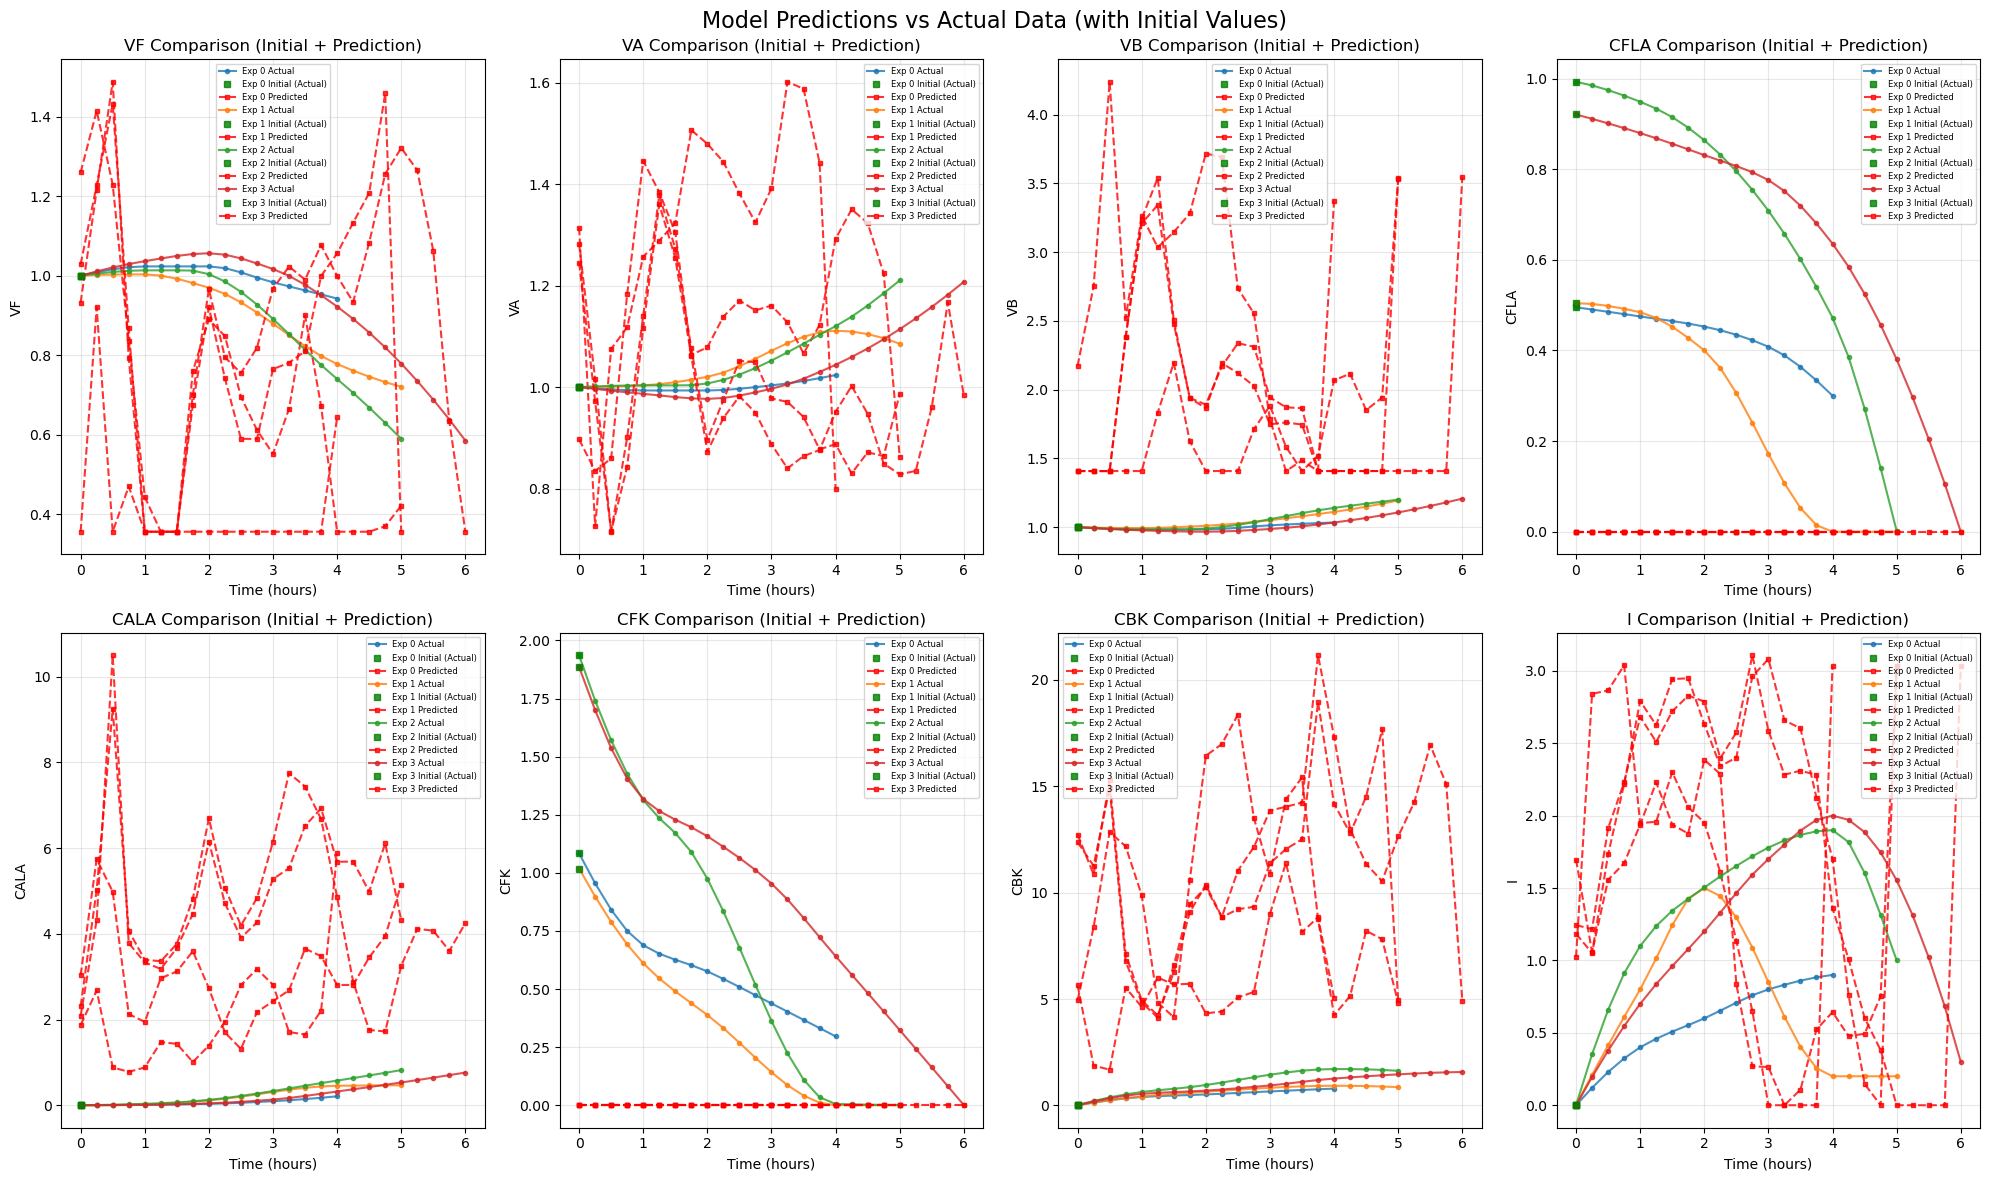


=== 수정된 예측 시각화 ===
초기값 문제가 해결된 그래프를 생성합니다...

수정된 그래프 - 실험 0...


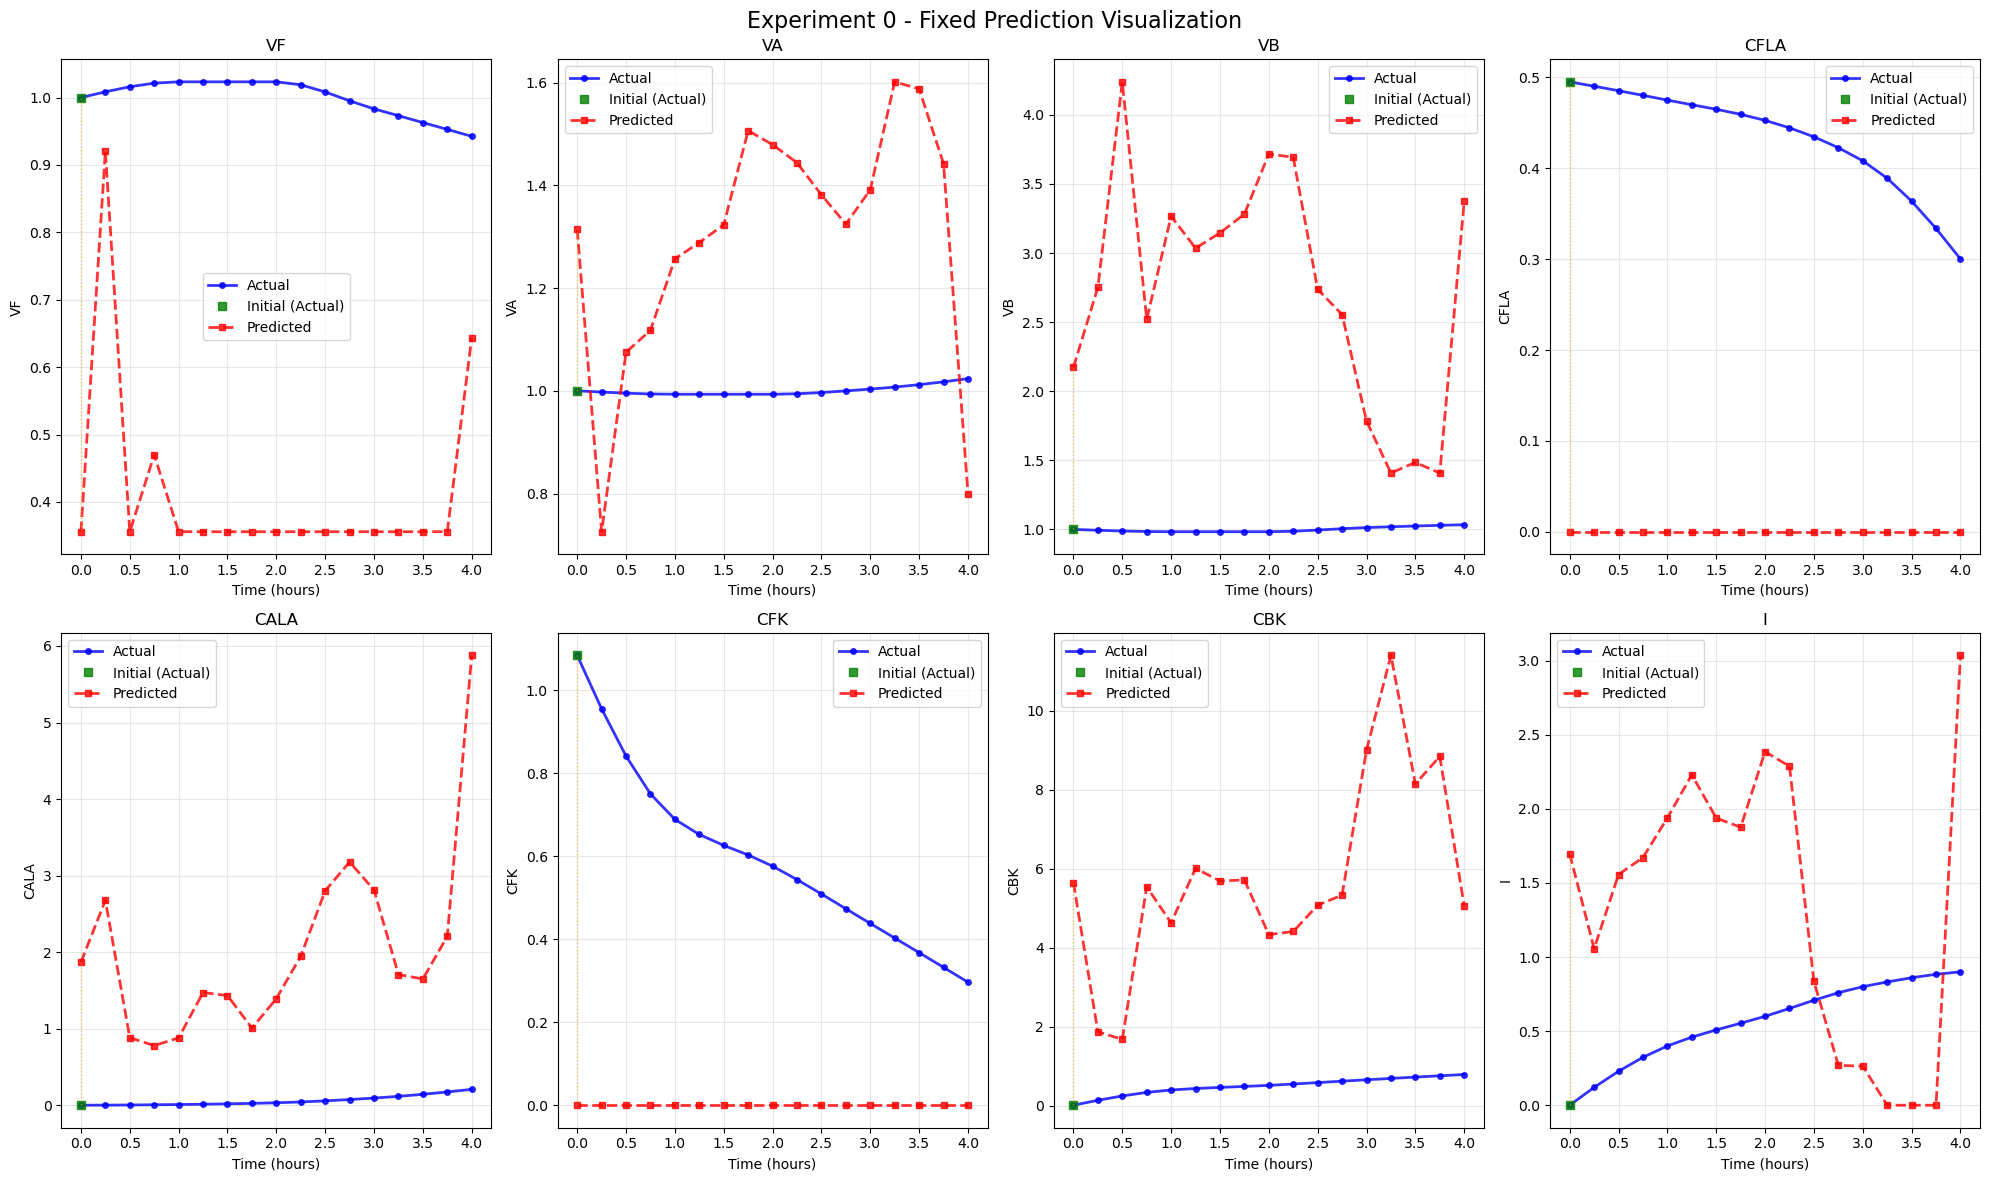


수정된 그래프 - 실험 1...


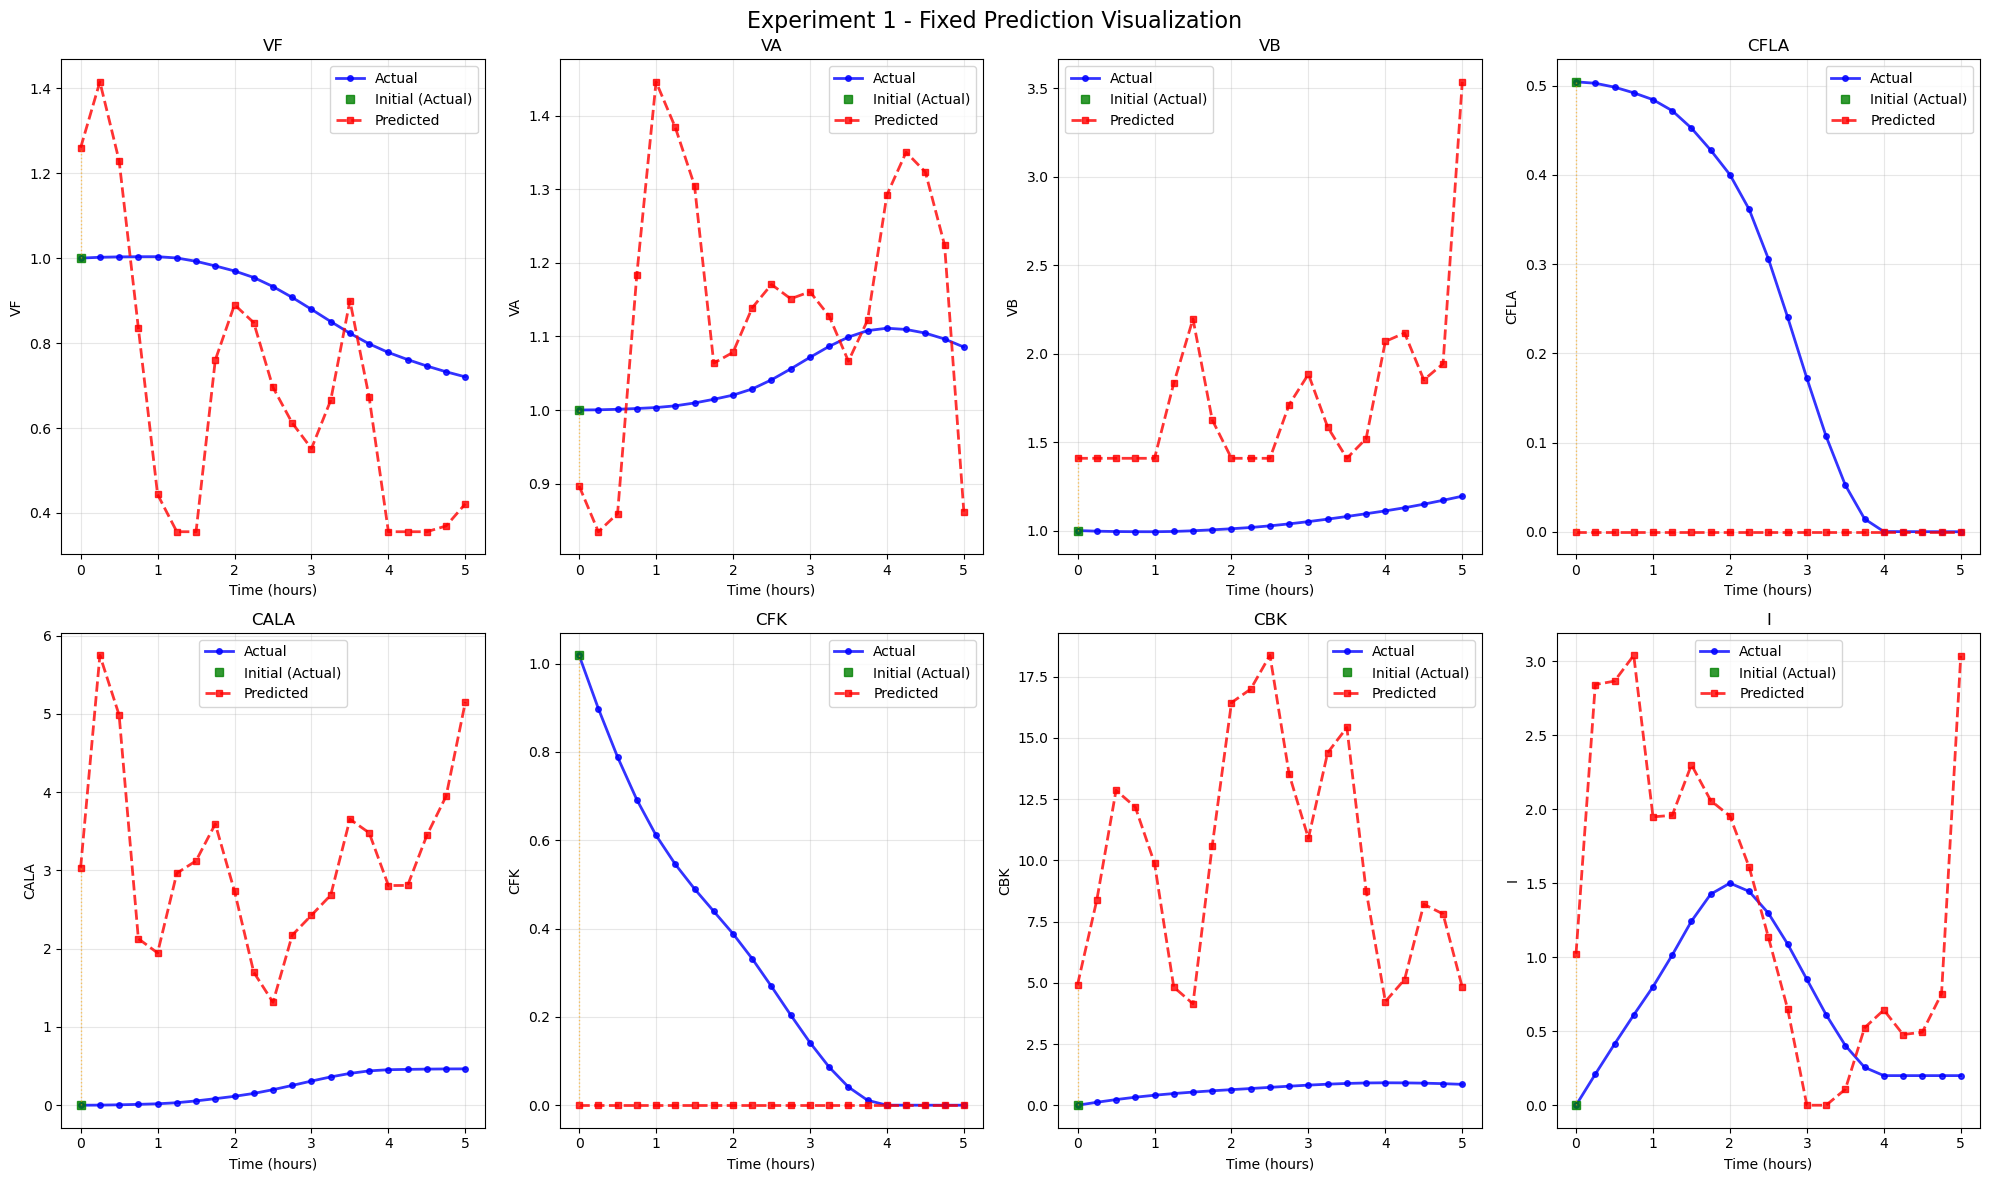


수정된 그래프 - 실험 2...


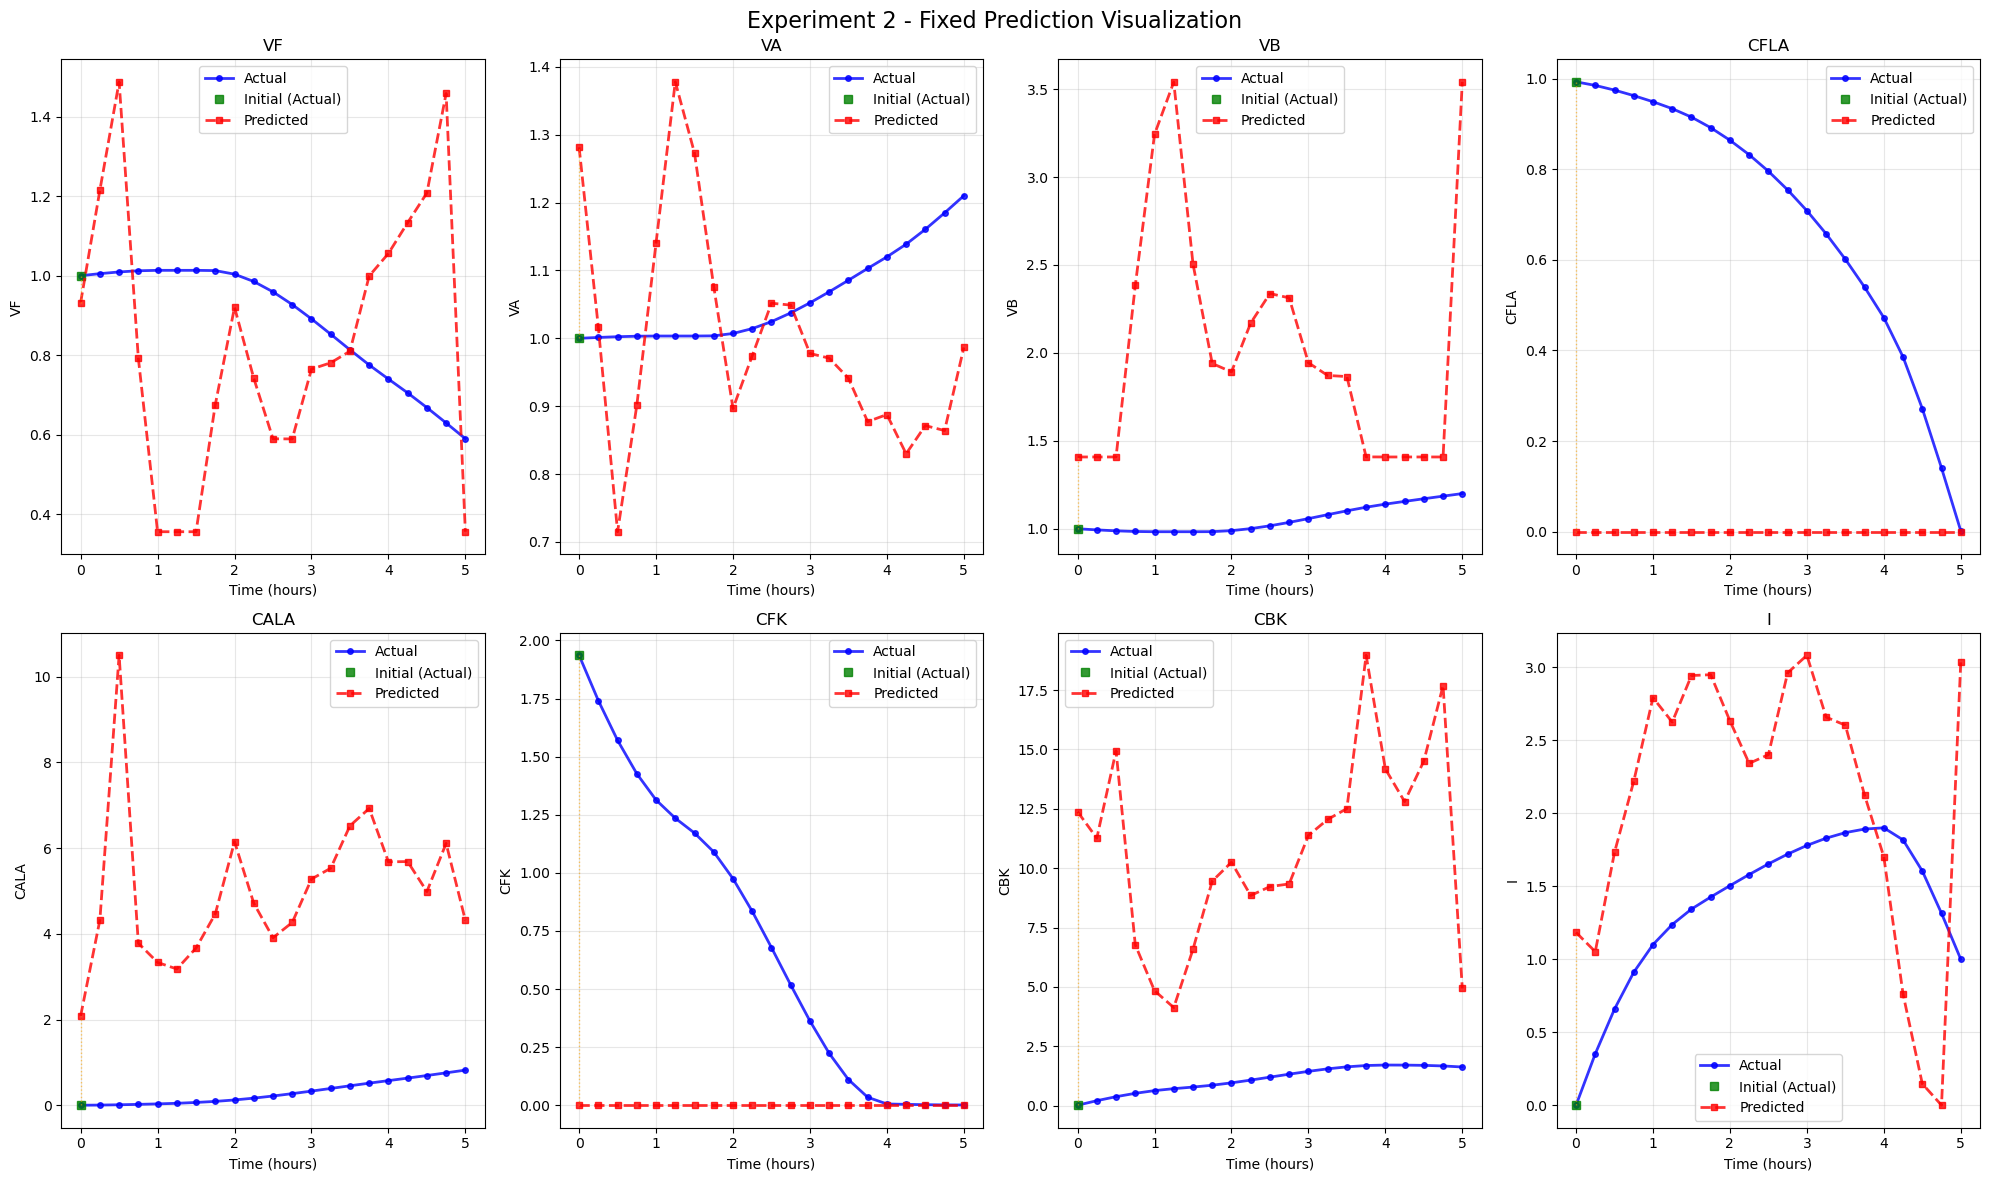


✅ 수정된 그래프 완료!

=== 해결된 문제점 ===
1. 초기값(t=0)을 실제값으로 표시
2. 예측값은 t=0.25부터 시작하는 것을 명확히 구분
3. 초기값에서 첫 번째 예측값까지 연결선 추가
4. 색상과 마커로 실제값, 초기값, 예측값 구분


In [100]:
# Generate predictions and compare with actual data
import matplotlib.pyplot as plt

# Load pre-trained model first
print("Loading pre-trained model from best_bmed_noam_model.pth...")
try:
    model.load_state_dict(torch.load('best_bmed_noam_model.pth', map_location=device))
    model.eval()
    print("✓ Pre-trained model loaded successfully!")
except FileNotFoundError:
    print("❌ Error: best_bmed_noam_model.pth not found in current directory")
    print("Please make sure the pre-trained model file exists.")
except Exception as e:
    print(f"❌ Error loading model: {str(e)}")

def predict_sequences(model, dataset, exp_num_list, device):
    """
    Generate predictions for all sequences in the dataset
    """
    model.eval()
    predictions = {}
    actual_data = {}
    
    with torch.no_grad():
        for idx, (input_seq, seq_length) in enumerate(dataset):
            exp_num = exp_num_list[idx]
            
            # Convert to tensors and move to device
            input_seq = input_seq.unsqueeze(0).to(device)  # Add batch dimension
            seq_length = seq_length.unsqueeze(0).to(device)
            print(input_seq)
            
            # Prepare input data (exclude current)
            inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_length)
            
            # Generate predictions
            pred = model(inputs, target_seq_lengths)
            
            # Store results
            predictions[exp_num] = pred.cpu().numpy().squeeze()  # Remove batch dimension
            actual_data[exp_num] = targets.cpu().numpy().squeeze()
    
    return predictions, actual_data

# Load actual data for comparison
actual_df = pd.read_csv('BMED_DATA_AG.csv')

# Recreate range_mm for denormalization (same as used in norm_data)
range_mm = {
    'V': {'min': actual_df['V'].min() * 0.8, 'max': actual_df['V'].max() * 1.2},
    'E': {'min': actual_df['E'].min() * 0.8, 'max': actual_df['E'].max() * 1.2},
    'VF': {'min': actual_df['VF'].min() * 0.8, 'max': actual_df['VF'].max() * 1.2},
    'VA': {'min': actual_df['VA'].min() * 0.8, 'max': actual_df['VA'].max() * 1.2},
    'VB': {'min': actual_df['VB'].min() * 0.8, 'max': actual_df['VB'].max() * 1.2},
    'CFLA': {'min': 0, 'max': actual_df['CFLA'].max() * 1.2},
    'CALA': {'min': 0, 'max': actual_df['CALA'].max() * 1.2},
    'CFK': {'min': 0, 'max': actual_df['CFK'].max() * 1.2},
    'CBK': {'min': 0, 'max': actual_df['CBK'].max() * 1.2},
    'I': {'min': 0, 'max': actual_df['I'].max() * 1.2},
}

print("Generating predictions for all experiments...")
predictions, actual_normalized = predict_sequences(model, dataset, exp_num_list, device)

# Create subplots for each feature (2x4 grid) - 수정된 버전
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

for feat_idx, (feature_name, pred_idx) in enumerate(zip(feature_names, prediction_feature_indices)):
    ax = axes[feat_idx]
    
    # Show first 4 experiments to avoid overcrowding
    for exp_num in unique_exps[:4]:  
        # Get actual data for this experiment
        exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
        time_points = exp_actual['t'].values
        actual_values = exp_actual[feature_name].values
        
        # Get predicted data
        if exp_num in predictions:
            pred_normalized = predictions[exp_num]
            if len(pred_normalized.shape) > 1 and pred_idx < pred_normalized.shape[1]:
                pred_values = pred_normalized[:, pred_idx]
                
                # Denormalize predictions
                if feature_name in range_mm:
                    pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                                 range_mm[feature_name]['min'])
                
                # 수정된 시간 정렬: 예측값은 t=0.25부터 시작
                pred_time = time_points[1:len(pred_values)+1] if len(pred_values) < len(time_points) else time_points[:len(pred_values)]
                
                # 초기값 포함한 완전한 예측 시계열 생성
                # 첫 번째 시점(t=0)은 실제값 사용, 나머지는 예측값
                full_pred_values = np.concatenate([actual_values[:1], pred_values[:len(pred_time)]])
                full_pred_time = np.concatenate([time_points[:1], pred_time])
                
                # Plot actual vs predicted
                ax.plot(time_points, actual_values, 'o-', label=f'Exp {exp_num} Actual', alpha=0.8, markersize=3, linewidth=1.5)
                
                # 초기값(실제값)과 예측값을 구분해서 표시
                ax.plot(full_pred_time[:1], full_pred_values[:1], 's', label=f'Exp {exp_num} Initial (Actual)', 
                       alpha=0.8, markersize=5, color='green')
                ax.plot(pred_time, pred_values[:len(pred_time)], 's--', label=f'Exp {exp_num} Predicted', 
                       alpha=0.8, markersize=3, linewidth=1.5, color='red')
    
    ax.set_title(f'{feature_name} Comparison (Initial + Prediction)')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel(feature_name)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=6)

plt.suptitle('Model Predictions vs Actual Data (with Initial Values)', fontsize=16)
plt.tight_layout()
plt.show()

# 개별 실험 비교 함수도 수정
def plot_experiment_comparison_fixed(exp_num, predictions, actual_df, range_mm, feature_names):
    """
    수정된 개별 실험 비교 플롯 - 초기값 문제 해결
    """
    if exp_num not in predictions:
        print(f"No predictions available for experiment {exp_num}")
        return
    
    # Get actual data for this experiment
    exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
    time_points = exp_actual['t'].values
    
    # Get predicted data
    pred_normalized = predictions[exp_num]
    
    # Create 2x4 subplot for this experiment
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    # Correct feature indices for predictions: [V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I]
    prediction_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # Skip V(0) and E(1)
    
    for feat_idx, feature_name in enumerate(feature_names):
        ax = axes[feat_idx]
        
        # Actual values
        actual_values = exp_actual[feature_name].values
        
        # Get predicted values with correct indexing
        if len(pred_normalized.shape) > 1 and feat_idx < len(prediction_indices):
            pred_idx = prediction_indices[feat_idx]
            pred_values = pred_normalized[:, pred_idx]
            
            # Denormalize predictions
            if feature_name in range_mm:
                pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                             range_mm[feature_name]['min'])
            
            # 수정된 시간 정렬
            pred_time = time_points[1:len(pred_values)+1] if len(pred_values) < len(time_points) else time_points[:len(pred_values)]
            
            # 초기값 포함한 완전한 예측 시계열 생성
            full_pred_values = np.concatenate([actual_values[:1], pred_values[:len(pred_time)]])
            full_pred_time = np.concatenate([time_points[:1], pred_time])
            
            # Plot
            ax.plot(time_points, actual_values, 'o-', label='Actual', color='blue', alpha=0.8, linewidth=2, markersize=4)
            
            # 초기값과 예측값 구분 표시
            ax.plot(full_pred_time[:1], full_pred_values[:1], 's', label='Initial (Actual)', 
                   color='green', alpha=0.8, markersize=6)
            ax.plot(pred_time, pred_values[:len(pred_time)], 's--', label='Predicted', 
                   color='red', alpha=0.8, linewidth=2, markersize=4)
            
            # 연결선 추가 (초기값에서 첫 번째 예측값까지)
            if len(pred_time) > 0:
                ax.plot([time_points[0], pred_time[0]], [actual_values[0], pred_values[0]], 
                       ':', color='orange', alpha=0.6, linewidth=1)
            
            # Calculate and display error metrics (예측값만 비교)
            if len(pred_values) <= len(actual_values) - 1:
                actual_subset = actual_values[1:len(pred_values)+1]
                if len(actual_subset) == len(pred_values[:len(actual_subset)]):
                    mse = np.mean((actual_subset - pred_values[:len(actual_subset)])**2)
                    rmse = np.sqrt(mse)
                    mae = np.mean(np.abs(actual_subset - pred_values[:len(actual_subset)]))
                    
                    # Calculate correlation
                    correlation = np.corrcoef(actual_subset, pred_values[:len(actual_subset)])[0, 1] if len(actual_subset) > 1 else 0
                    
                    ax.text(0.02, 0.98, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nCorr: {correlation:.3f}', 
                           transform=ax.transAxes, verticalalignment='top', 
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'No prediction data', transform=ax.transAxes, ha='center', va='center')
        
        ax.set_title(f'{feature_name}')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel(feature_name)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle(f'Experiment {exp_num} - Fixed Prediction Visualization', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# 수정된 함수로 다시 플롯
print("\n=== 수정된 예측 시각화 ===")
print("초기값 문제가 해결된 그래프를 생성합니다...")

for exp_num in available_exps[:3]:  # Show first 3 available experiments
    print(f"\n수정된 그래프 - 실험 {exp_num}...")
    plot_experiment_comparison_fixed(exp_num, predictions, actual_df, range_mm, feature_names)

print(f"\n✅ 수정된 그래프 완료!")
print("\n=== 해결된 문제점 ===")
print("1. 초기값(t=0)을 실제값으로 표시")
print("2. 예측값은 t=0.25부터 시작하는 것을 명확히 구분")
print("3. 초기값에서 첫 번째 예측값까지 연결선 추가")
print("4. 색상과 마커로 실제값, 초기값, 예측값 구분")

Creating detailed comparison plots for individual experiments...
Available experiments for detailed plots: [0, 1, 2, 3, 4, 5]
\nPlotting detailed comparison for experiment 0...


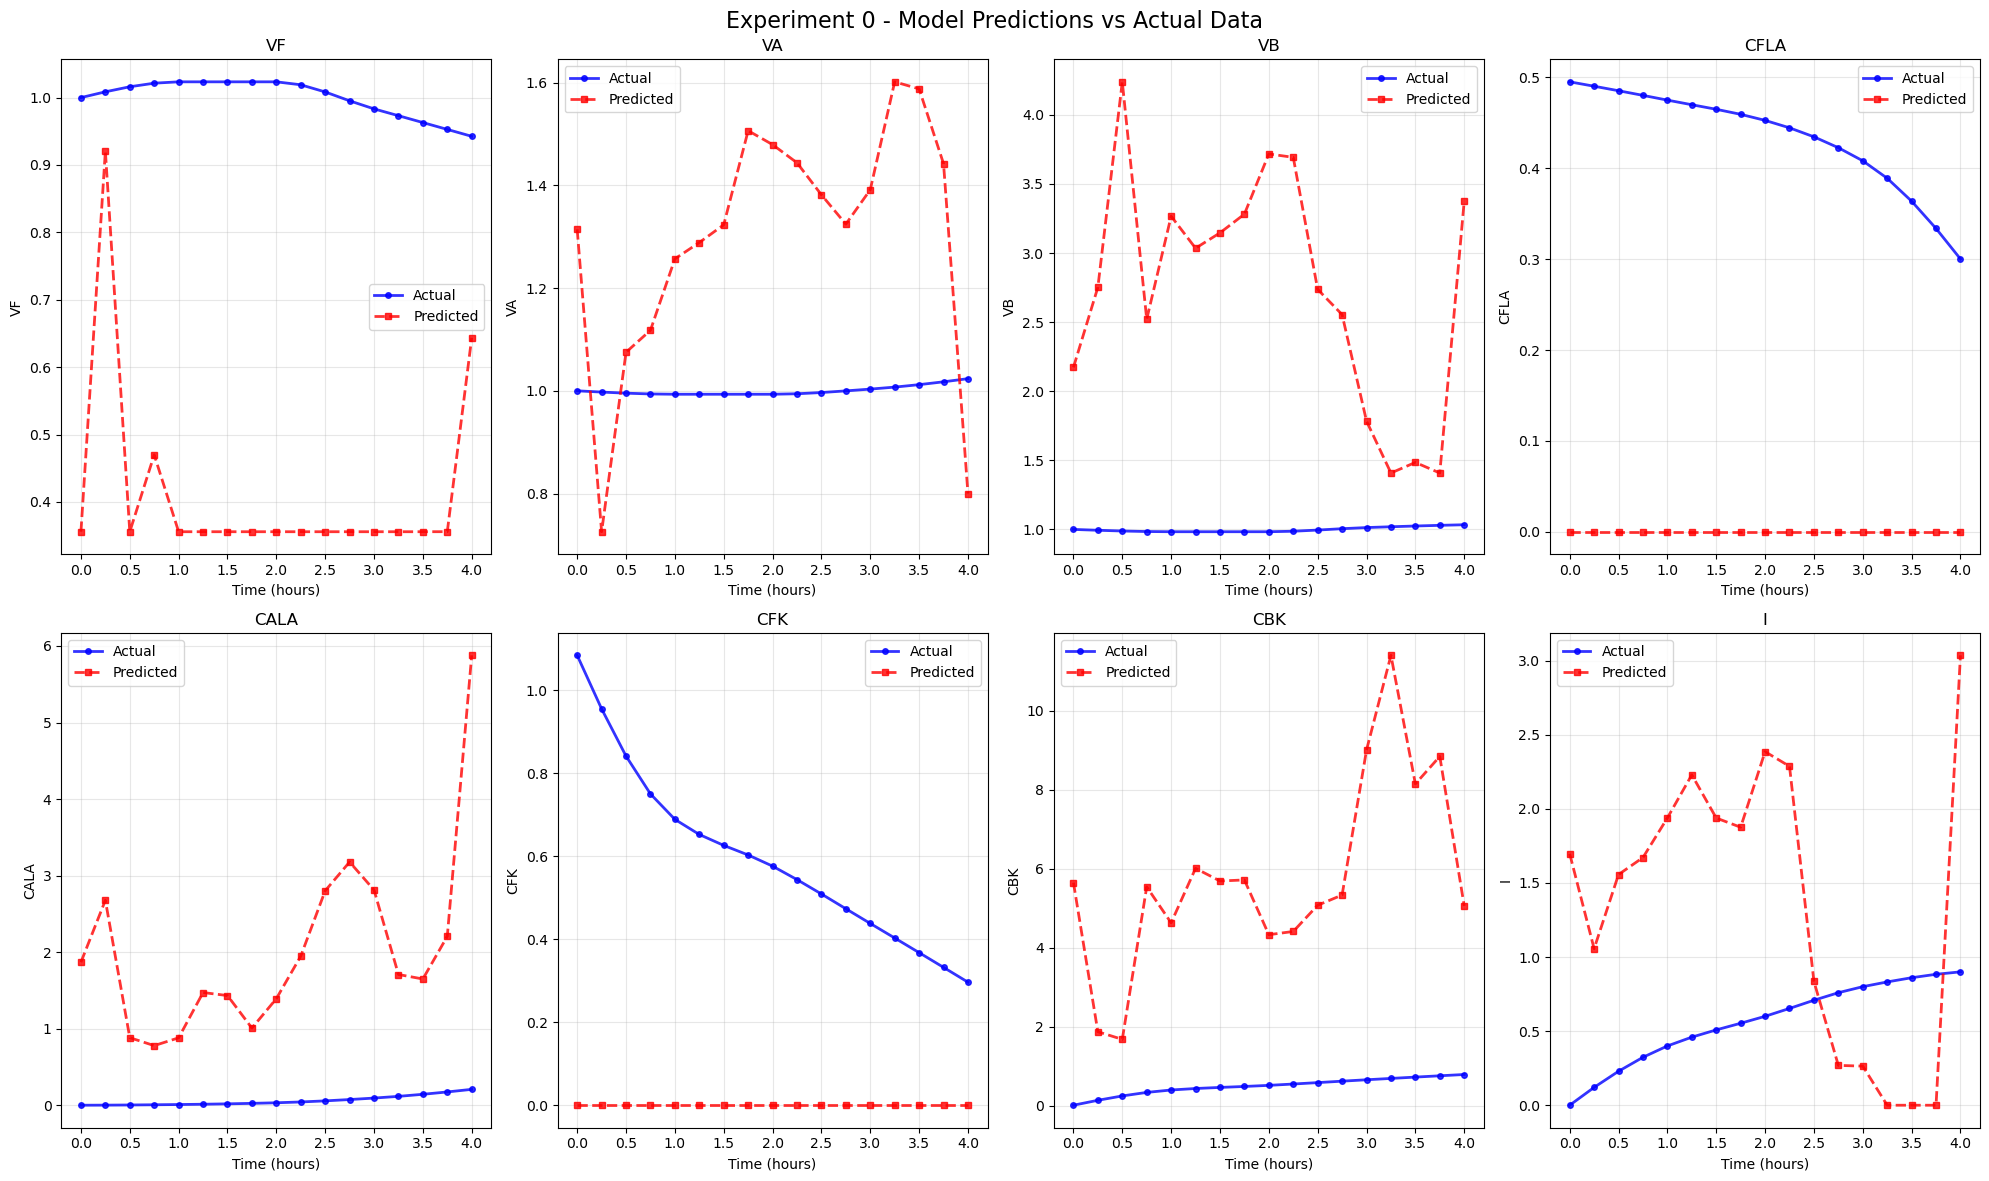

\nPlotting detailed comparison for experiment 1...


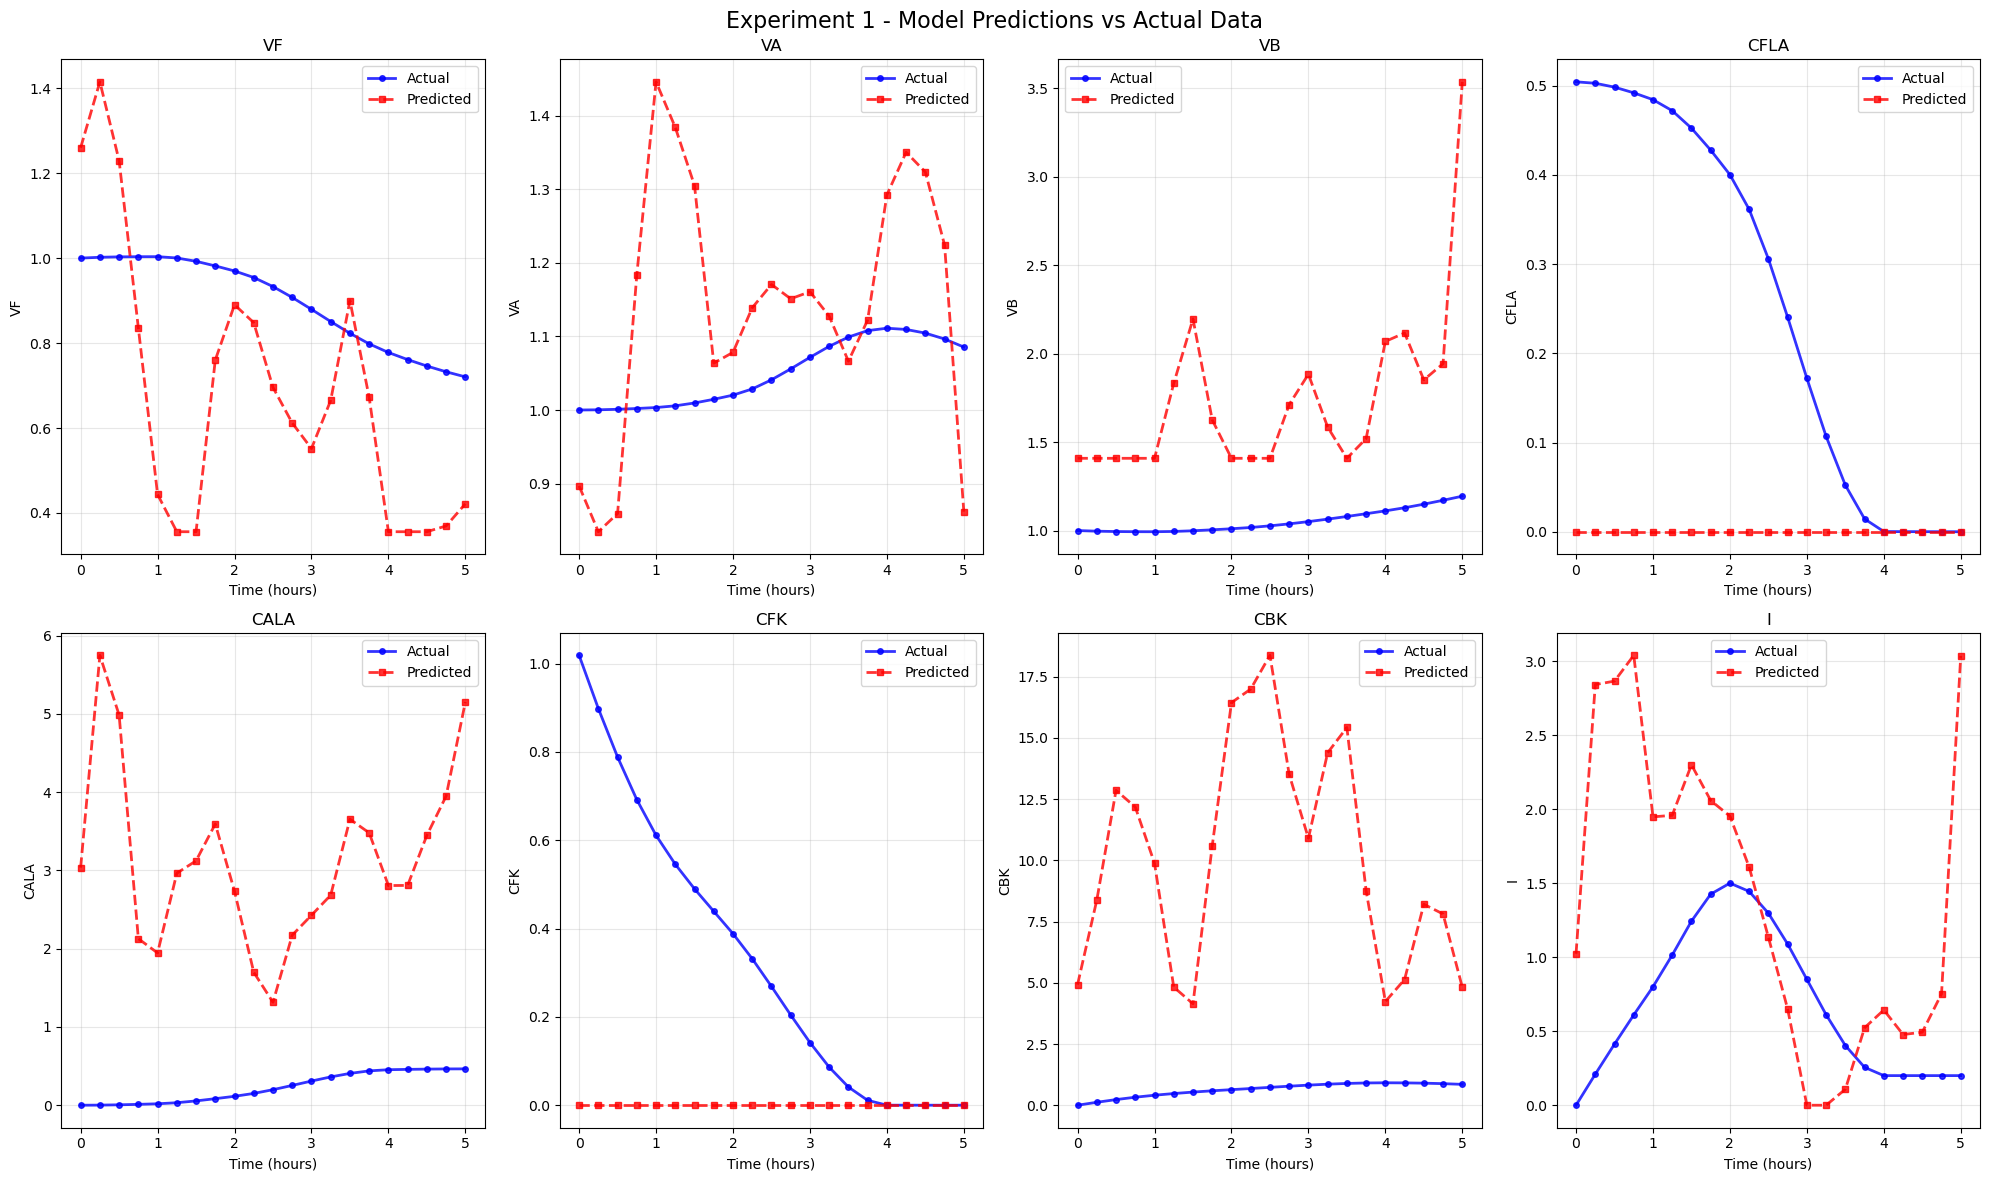

\nPlotting detailed comparison for experiment 2...


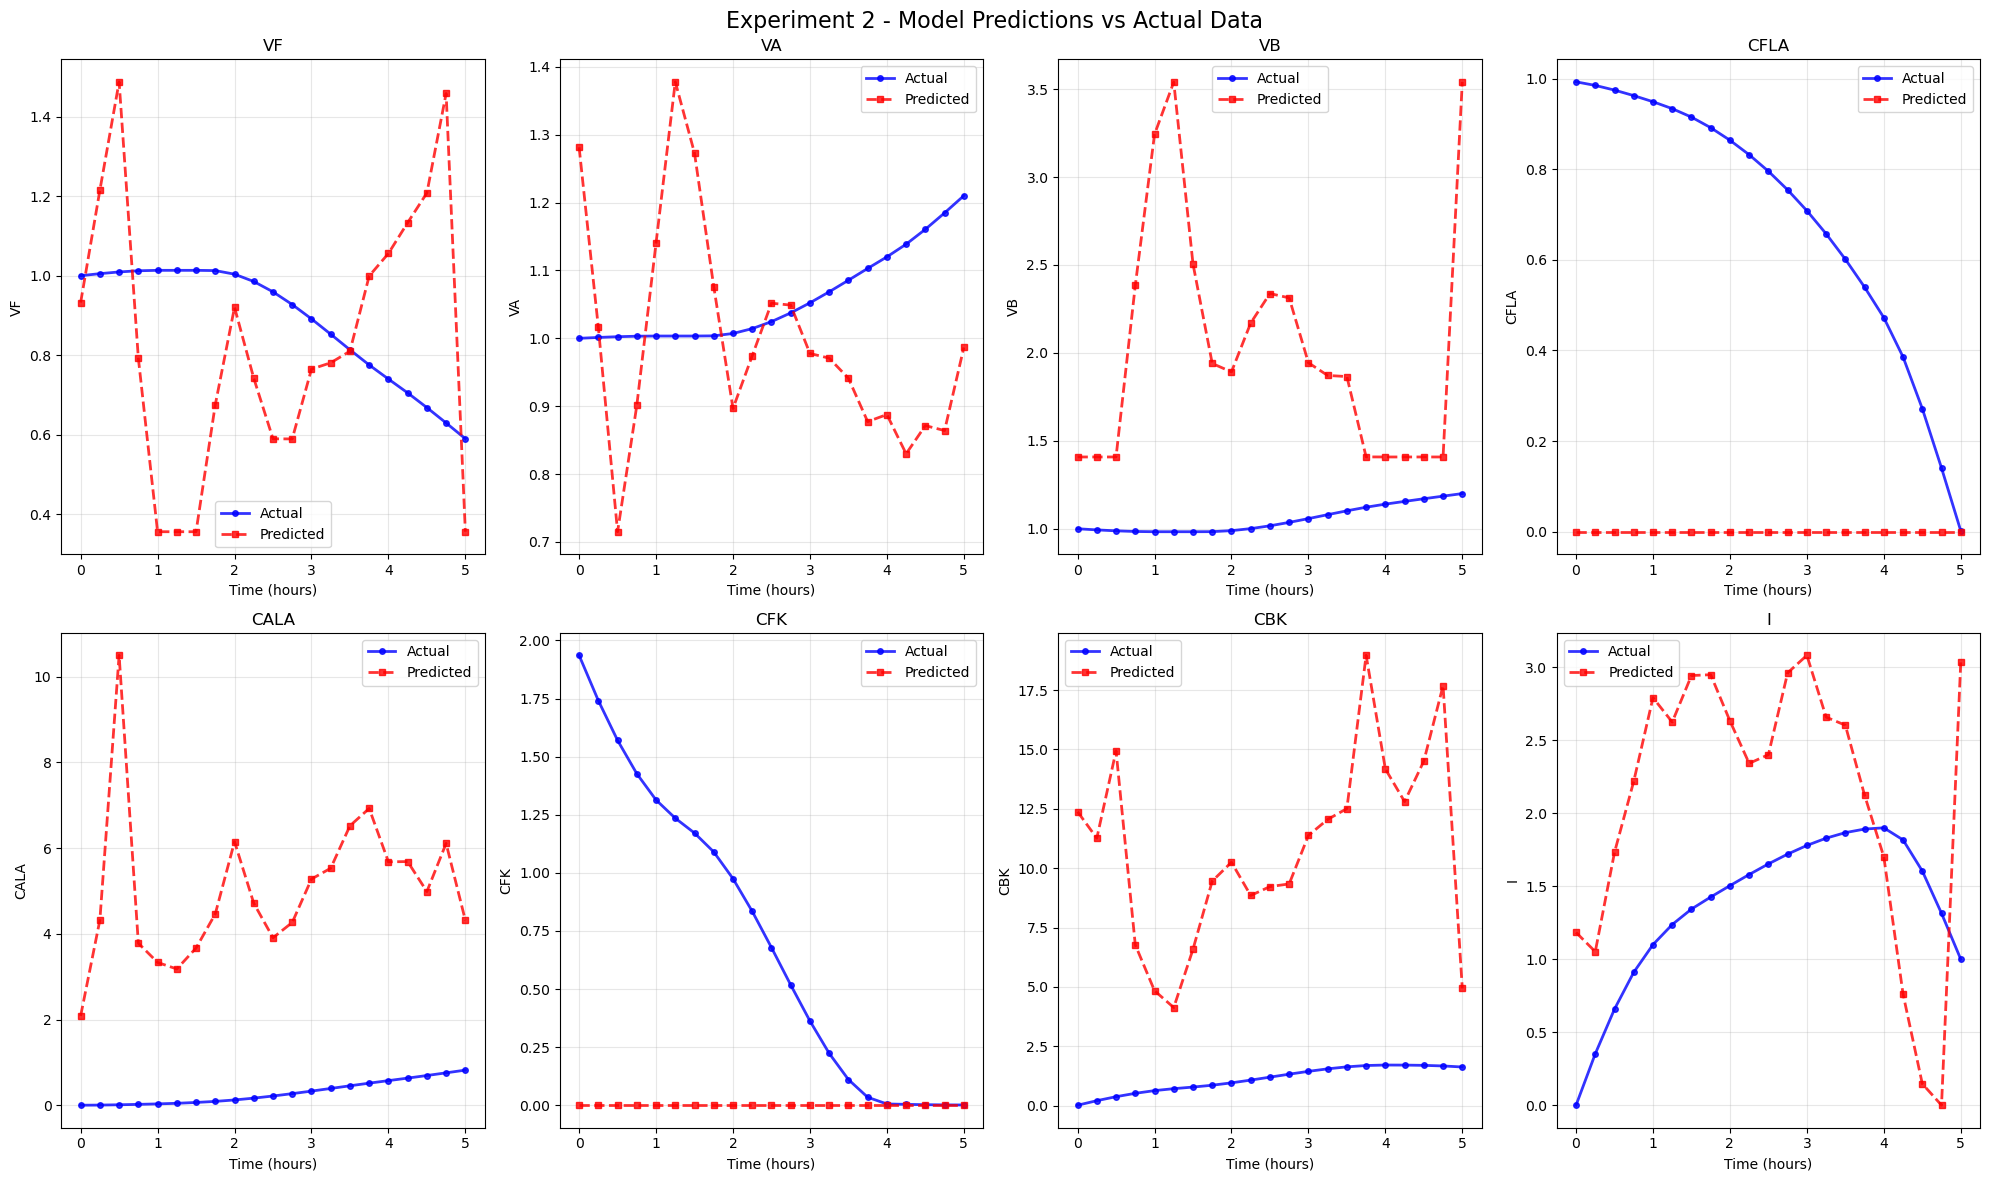

\n✅ Completed detailed plotting for experiments: [0, 1, 2]
\n=== Debugging Information ===
Experiment 0 prediction shape: (32, 10)
  Sample time points: [0.   0.25 0.5 ]
  Sample VF actual: [1.         1.00859636 1.01609532]
  Sample VF predicted (normalized): [0.1       0.4403882 0.1      ]
Experiment 1 prediction shape: (32, 10)
  Sample time points: [0.   0.25 0.5 ]
  Sample VF actual: [1.         1.00193353 1.00292642]
  Sample VF predicted (normalized): [0.6449015 0.738397  0.6265391]
Experiment 2 prediction shape: (32, 10)
  Sample time points: [0.   0.25 0.5 ]
  Sample VF actual: [1.         1.00515203 1.00945946]
  Sample VF predicted (normalized): [0.44754836 0.6179135  0.78229636]


In [101]:
# Create individual experiment comparison plots with correct indexing
def plot_experiment_comparison(exp_num, predictions, actual_df, range_mm, feature_names):
    """
    Create subplot for a single experiment comparing all features with correct indexing
    """
    if exp_num not in predictions:
        print(f"No predictions available for experiment {exp_num}")
        return
    
    # Get actual data for this experiment
    exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
    time_points = exp_actual['t'].values
    
    # Get predicted data
    pred_normalized = predictions[exp_num]
    
    # Create 2x4 subplot for this experiment
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    # Correct feature indices for predictions: [V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I]
    prediction_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # Skip V(0) and E(1)
    
    for feat_idx, feature_name in enumerate(feature_names):
        ax = axes[feat_idx]
        
        # Actual values
        actual_values = exp_actual[feature_name].values
        
        # Get predicted values with correct indexing
        if len(pred_normalized.shape) > 1 and feat_idx < len(prediction_indices):
            pred_idx = prediction_indices[feat_idx]
            pred_values = pred_normalized[:, pred_idx]
            
            # Denormalize predictions
            if feature_name in range_mm:
                pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                             range_mm[feature_name]['min'])
            
            # Align time points (predictions start from t=0.25)
            pred_time = time_points[1:len(pred_values)+1] if len(pred_values) < len(time_points) else time_points[:len(pred_values)]
            
            # Plot
            ax.plot(time_points, actual_values, 'o-', label='Actual', color='blue', alpha=0.8, linewidth=2, markersize=4)
            ax.plot(pred_time, pred_values[:len(pred_time)], 's--', label='Predicted', color='red', alpha=0.8, linewidth=2, markersize=4)
            
            # Calculate and display error metrics
            if len(pred_values) <= len(actual_values) - 1:
                actual_subset = actual_values[1:len(pred_values)+1]
                if len(actual_subset) == len(pred_values[:len(actual_subset)]):
                    mse = np.mean((actual_subset - pred_values[:len(actual_subset)])**2)
                    rmse = np.sqrt(mse)
                    mae = np.mean(np.abs(actual_subset - pred_values[:len(actual_subset)]))
                    
                    # Calculate correlation
                    correlation = np.corrcoef(actual_subset, pred_values[:len(actual_subset)])[0, 1] if len(actual_subset) > 1 else 0
                    
                    ax.text(0.02, 0.98, f'RMSE: {rmse:.4f}\\nMAE: {mae:.4f}\\nCorr: {correlation:.3f}', 
                           transform=ax.transAxes, verticalalignment='top', 
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'No prediction data', transform=ax.transAxes, ha='center', va='center')
        
        ax.set_title(f'{feature_name}')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel(feature_name)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle(f'Experiment {exp_num} - Model Predictions vs Actual Data', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot comparisons for selected experiments
print("Creating detailed comparison plots for individual experiments...")

# Select experiments to show (first few available ones)
sample_experiments = [0, 1, 2, 3, 4, 5]
available_exps = [exp for exp in sample_experiments if exp in predictions]

print(f"Available experiments for detailed plots: {available_exps}")

for exp_num in available_exps[:3]:  # Show first 3 available experiments
    print(f"\\nPlotting detailed comparison for experiment {exp_num}...")
    plot_experiment_comparison(exp_num, predictions, actual_df, range_mm, feature_names)

print(f"\\n✅ Completed detailed plotting for experiments: {available_exps[:3]}")

# Print prediction statistics for debugging
print(f"\\n=== Debugging Information ===")
for exp_num in available_exps[:3]:
    if exp_num in predictions:
        pred_shape = predictions[exp_num].shape
        print(f"Experiment {exp_num} prediction shape: {pred_shape}")
        
        # Show a sample of predictions vs actuals for first few time points
        exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
        print(f"  Sample time points: {exp_actual['t'].values[:3]}")
        print(f"  Sample VF actual: {exp_actual['VF'].values[:3]}")
        if len(predictions[exp_num].shape) > 1:
            print(f"  Sample VF predicted (normalized): {predictions[exp_num][:3, 2]}")  # VF is index 2

In [ ]:
# Model Evaluation: Feature-wise Analysis and Visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model_performance(predictions, actual_df, range_mm, feature_names):
    """
    Comprehensive model evaluation with feature-wise analysis
    """
    print("🔍 MODEL PERFORMANCE EVALUATION")
    print("=" * 50)
    
    results = {}
    prediction_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # Skip V(0) and E(1)
    
    # Collect all predictions and actuals for each feature
    for feat_idx, feature_name in enumerate(feature_names):
        all_actual = []
        all_predicted = []
        
        for exp_num in sorted(predictions.keys()):
            # Get actual data
            exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
            actual_values = exp_actual[feature_name].values
            
            # Get predicted data
            if exp_num in predictions:
                pred_normalized = predictions[exp_num]
                if len(pred_normalized.shape) > 1 and feat_idx < len(prediction_indices):
                    pred_idx = prediction_indices[feat_idx]
                    pred_values = pred_normalized[:, pred_idx]
                    
                    # Denormalize predictions
                    if feature_name in range_mm:
                        pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                                     range_mm[feature_name]['min'])
                    
                    # Align data (skip first time point as it's used as input)
                    if len(pred_values) <= len(actual_values) - 1:
                        actual_subset = actual_values[1:len(pred_values)+1]
                        all_actual.extend(actual_subset)
                        all_predicted.extend(pred_values[:len(actual_subset)])
        
        # Calculate metrics
        if len(all_actual) > 0 and len(all_predicted) > 0:
            all_actual = np.array(all_actual)
            all_predicted = np.array(all_predicted)
            
            mse = mean_squared_error(all_actual, all_predicted)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(all_actual, all_predicted)
            r2 = r2_score(all_actual, all_predicted)
            
            # Calculate percentage errors
            mape = np.mean(np.abs((all_actual - all_predicted) / (all_actual + 1e-8))) * 100
            
            results[feature_name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'MAPE': mape,
                'actual': all_actual,
                'predicted': all_predicted
            }
            
            print(f"{feature_name:8}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.3f}, MAPE={mape:.1f}%")
    
    return results

def plot_feature_wise_analysis(results, feature_names):
    """
    Create comprehensive feature-wise plots
    """
    # 1. Performance metrics comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    metrics = ['RMSE', 'MAE', 'R²', 'MAPE']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        values = [results[fname][metric] for fname in feature_names if fname in results]
        bars = ax.bar(feature_names[:len(values)], values, color=colors[i], alpha=0.7)
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{val:.3f}' if metric != 'MAPE' else f'{val:.1f}%',
                   ha='center', va='bottom', fontsize=10)
        
        ax.set_title(f'{metric} by Feature')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Actual vs Predicted scatter plots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(feature_names):
        if feature_name in results:
            ax = axes[i]
            actual = results[feature_name]['actual']
            predicted = results[feature_name]['predicted']
            
            # Scatter plot
            ax.scatter(actual, predicted, alpha=0.6, s=20)
            
            # Perfect prediction line
            min_val = min(actual.min(), predicted.min())
            max_val = max(actual.max(), predicted.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Prediction')
            
            # R² and RMSE on plot
            r2 = results[feature_name]['R²']
            rmse = results[feature_name]['RMSE']
            ax.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.4f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlabel(f'Actual {feature_name}')
            ax.set_ylabel(f'Predicted {feature_name}')
            ax.set_title(f'{feature_name} Prediction Accuracy')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Residuals analysis
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(feature_names):
        if feature_name in results:
            ax = axes[i]
            actual = results[feature_name]['actual']
            predicted = results[feature_name]['predicted']
            residuals = actual - predicted
            
            # Residuals vs predicted
            ax.scatter(predicted, residuals, alpha=0.6, s=20)
            ax.axhline(y=0, color='r', linestyle='--', alpha=0.8)
            
            # Add mean and std of residuals
            mean_residual = np.mean(residuals)
            std_residual = np.std(residuals)
            ax.text(0.05, 0.95, f'Mean: {mean_residual:.4f}\nStd: {std_residual:.4f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlabel(f'Predicted {feature_name}')
            ax.set_ylabel('Residuals')
            ax.set_title(f'{feature_name} Residuals')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_time_series_by_feature(predictions, actual_df, range_mm, feature_names):
    """
    Plot time series for each feature across all experiments
    """
    prediction_indices = [2, 3, 4, 5, 6, 7, 8, 9]
    
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flatten()
    
    for feat_idx, feature_name in enumerate(feature_names):
        ax = axes[feat_idx]
        
        # Plot each experiment
        for exp_num in sorted(list(predictions.keys())[:6]):  # First 6 experiments
            # Actual data
            exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
            time_points = exp_actual['t'].values
            actual_values = exp_actual[feature_name].values
            
            # Predicted data
            if exp_num in predictions:
                pred_normalized = predictions[exp_num]
                if len(pred_normalized.shape) > 1 and feat_idx < len(prediction_indices):
                    pred_idx = prediction_indices[feat_idx]
                    pred_values = pred_normalized[:, pred_idx]
                    
                    # Denormalize
                    if feature_name in range_mm:
                        pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                                     range_mm[feature_name]['min'])
                    
                    pred_time = time_points[1:len(pred_values)+1]
                    
                    # Plot
                    ax.plot(time_points, actual_values, '-', alpha=0.7, linewidth=1.5, 
                           label=f'Exp {exp_num} Actual' if exp_num == sorted(list(predictions.keys()))[0] else '')
                    ax.plot(pred_time, pred_values[:len(pred_time)], '--', alpha=0.7, linewidth=1.5,
                           label=f'Exp {exp_num} Pred' if exp_num == sorted(list(predictions.keys()))[0] else '')
        
        ax.set_title(f'{feature_name} Time Series')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel(feature_name)
        ax.grid(True, alpha=0.3)
        if feat_idx == 0:
            ax.legend()
    
    plt.suptitle('Time Series Comparison: All Features Across Experiments', fontsize=16)
    plt.tight_layout()
    plt.show()

# Run the evaluation
print("🚀 Starting comprehensive model evaluation...")

# Evaluate model performance
performance_results = evaluate_model_performance(predictions, actual_df, range_mm, feature_names)

print(f"\n📊 Creating detailed visualizations...")

# Create comprehensive plots
plot_feature_wise_analysis(performance_results, feature_names)
plot_time_series_by_feature(predictions, actual_df, range_mm, feature_names)

print(f"\n✅ Model evaluation completed!")
print(f"📈 Performance Summary:")
print(f"   - Total experiments evaluated: {len(predictions)}")
print(f"   - Features analyzed: {len(feature_names)}")
print(f"   - Best performing features (by R²): ", end="")

# Find best features by R²
if performance_results:
    best_features = sorted([(fname, results['R²']) for fname, results in performance_results.items()], 
                          key=lambda x: x[1], reverse=True)[:3]
    print(", ".join([f"{fname} ({r2:.3f})" for fname, r2 in best_features]))